# Generate patches for SAR Data

Here we experiment the proprocessing steps for the sar image

In [1]:
import glob
import random
from imz2mat import *
from utils import *
import cv2
import matplotlib.pyplot as plt
import scipy 
from utils_train import data_augmentation

%matplotlib inline

In [ ]:
scipy.misc

The function below are in utils.py

In [2]:
def min_max_scale(image, normal=True):
    """
    image between 0 and 1 or 0 and 255
    according to normal
    """
    img = image.copy()
    out = (img-img.min())/(img.max()-img.min())
    if(normal):
        out = out * 255
        return out.astype(np.uint8)
    else:
        return out
def quant_thresh(img):
    """
    threshold the image according to the quantile
    """
    pmax = np.percentile(img, 99)
    pmin = np.percentile(img, 1)
    out = img.copy()
    out[img>pmax] = pmax
    out[img<pmin] = pmin
    return out

def robust_scale(img):
    """
    perform log + quantile threshold+ min_max_thresh
    """
    return min_max_scale(quant_thresh(np.log(img)))

## Exemple of the robust scale
we print here the results

imz2mat : version Septembre 2017
Dans ximaread : image monocanal
Dans ximaread : lecture du canal 0/1
image en .imw
image en .imw
image en unsigned short 1024   1024   canaux: 1  verif :  0
lecture de  data/PileDomancy_moyennearithmetique.imw  en quelconque 1024 1024 1  offset  0 >H 2  complex 0 blocksize 2097152
Données réelles. Nouvelle version de imz2mat  >H


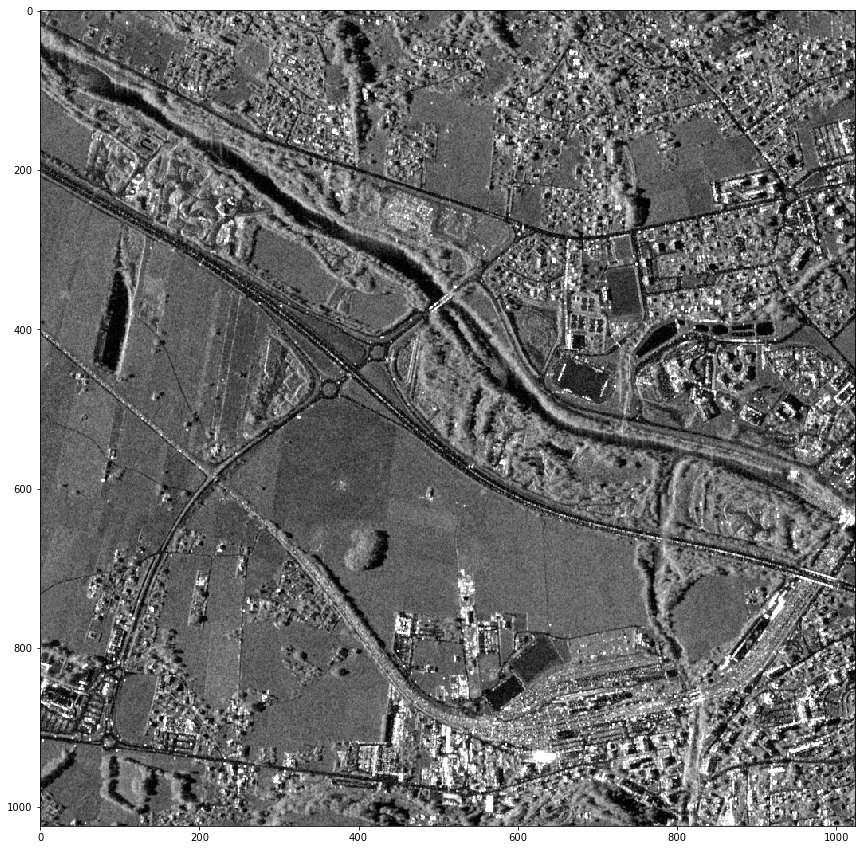

In [2]:
img = imz2mat('data/PileDomancy_moyennearithmetique.imw')[0]
rob_img = robust_scale(img)
plt.figure(figsize=(20, 15))
#displayRSO(img)

plt.imshow(rob_img, cmap='gray')

We now look at the histogram to see how the repartition of the values

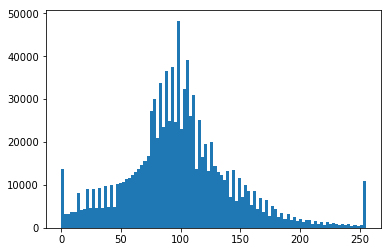

In [3]:
u = plt.hist(rob_img.ravel(), 100)

We compare with a natural image

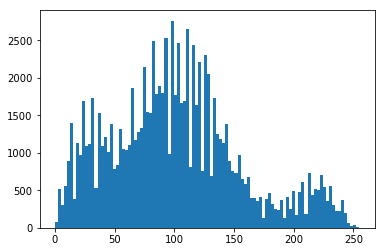

In [4]:
a = cv2.imread("data/Train400/test_020.png")
rob_a = min_max_scale(a)
u = plt.hist(rob_a.ravel(),100)

In [6]:
a.size

97200

In [7]:
filepaths = glob.glob("data/" + '/*.im[w,f]')
print(filepaths)

['data/pileRisoul_moy.imw', 'data/PileDomancy_moyennearithmetique.imw', 'data/PileSaintGervais_moyennearithmetique.imf', 'data/saclay_moy.imw']


## Generate patches for the SAR images

In [5]:
DATA_AUG_TIMES = 1
def generate_patches(isDebug=False, step=0, stride=10, pat_size=40, bat_size=128):
    """
    This function generates patches
    it is in the file generate_patch_sar
    """
    global DATA_AUG_TIMES
    count = 0
    filepaths = glob.glob("data/" + '/*.imw')
    if isDebug:
        filepaths = filepaths[:10]
    print("number of training data %d" % len(filepaths))
    
    scales = [1, 0.9, 0.8, 0.7]
    
    # calculate the number of patches
    for i in range(len(filepaths)):
        img =  imz2mat(filepaths[i])[0]# convert RGB to gray
        for s in range(len(scales)):
            newsize = (int(img.shape[0] * scales[s]), int(img.shape[1] * scales[s]))
            img_s = scipy.misc.imresize(img, size=newsize, interp='bicubic')  # do not change the original img
            im_h, im_w = img_s.shape
            for x in range(0 + step, (im_h - pat_size), stride):
                for y in range(0 + step, (im_w - pat_size), stride):
                    count += 1
    origin_patch_num = count * DATA_AUG_TIMES
    
    if origin_patch_num % bat_size != 0:
        numPatches = int((origin_patch_num / bat_size + 1) * bat_size)
    else:
        numPatches = origin_patch_num
    print("total patches = %d , batch size = %d, total batches = %d" % 
          (numPatches, bat_size, numPatches / bat_size))
    
    # data matrix 4-D
    inputs = np.zeros((numPatches, pat_size, pat_size, 1), dtype="uint8")
    
    count = 0
    # generate patches
    for i in range(len(filepaths)):
        img = imz2mat(filepaths[i])[0]
        img = robust_scale(img)
        for s in range(len(scales)):
            newsize = (int(img.shape[0] * scales[s]), int(img.shape[1] * scales[s]))
            # print newsize
            img_s = scipy.misc.imresize(img, size=newsize, interp='bicubic')
            img_s = np.reshape(np.array(img_s, dtype="uint8"),
                               (img_s.shape[0], img_s.shape[1], 1))  # extend one dimension
            
            for j in range(DATA_AUG_TIMES):
                im_h, im_w, _ = img_s.shape
                for x in range(0 + step, im_h - pat_size, stride):
                    for y in range(0 + step, im_w - pat_size, stride):
                        inputs[count, :, :, :] = data_augmentation(img_s[x:x + pat_size, y:y + pat_size, :],
                                                                   random.randint(0, 7))
                        count += 1
    # pad the batch
    if count < numPatches:
        to_pad = numPatches - count
        inputs[-to_pad:, :, :, :] = inputs[:to_pad, :, :, :]
    
    return inputs


In [6]:
inputs = generate_patches()

number of training data 3
imz2mat : version Septembre 2017
Dans ximaread : image monocanal
Dans ximaread : lecture du canal 0/1
image en .imw
image en .imw
image en unsigned short 2048   1024   canaux: 1  verif :  0
lecture de  data/pileRisoul_moy.imw  en quelconque 2048 1024 1  offset  0 >H 2  complex 0 blocksize 4194304
Données réelles. Nouvelle version de imz2mat  >H


/home/soso/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


imz2mat : version Septembre 2017
Dans ximaread : image monocanal
Dans ximaread : lecture du canal 0/1
image en .imw
image en .imw
image en unsigned short 1024   1024   canaux: 1  verif :  0
lecture de  data/PileDomancy_moyennearithmetique.imw  en quelconque 1024 1024 1  offset  0 >H 2  complex 0 blocksize 2097152
Données réelles. Nouvelle version de imz2mat  >H
imz2mat : version Septembre 2017
Dans ximaread : image monocanal
Dans ximaread : lecture du canal 0/1
image en .imw
image en .imw
image en unsigned short 1536   1024   canaux: 1  verif :  0
lecture de  data/saclay_moy.imw  en quelconque 1536 1024 1  offset  0 >H 2  complex 0 blocksize 3145728
Données réelles. Nouvelle version de imz2mat  >H
total patches = 129785 , batch size = 128, total batches = 1013
imz2mat : version Septembre 2017
Dans ximaread : image monocanal
Dans ximaread : lecture du canal 0/1
image en .imw
image en .imw
image en unsigned short 2048   1024   canaux: 1  verif :  0
lecture de  data/pileRisoul_moy.imw  en

/home/soso/Documents/cours/telecom/MVA/Remote_sensing/projet/RadarDenoising/utils.py:99: RuntimeWarning: divide by zero encountered in log
  return min_max_scale(quant_thresh(np.log(img)))
/home/soso/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


imz2mat : version Septembre 2017
Dans ximaread : image monocanal
Dans ximaread : lecture du canal 0/1
image en .imw
image en .imw
image en unsigned short 1024   1024   canaux: 1  verif :  0
lecture de  data/PileDomancy_moyennearithmetique.imw  en quelconque 1024 1024 1  offset  0 >H 2  complex 0 blocksize 2097152
Données réelles. Nouvelle version de imz2mat  >H
imz2mat : version Septembre 2017
Dans ximaread : image monocanal
Dans ximaread : lecture du canal 0/1
image en .imw
image en .imw
image en unsigned short 1536   1024   canaux: 1  verif :  0
lecture de  data/saclay_moy.imw  en quelconque 1536 1024 1  offset  0 >H 2  complex 0 blocksize 3145728
Données réelles. Nouvelle version de imz2mat  >H


We display the patches to see the difference

In [10]:
list_p = np.load('data/img_clean_pats.npy')

(28558, 40, 40, 1)


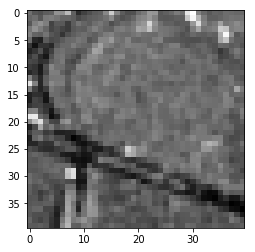

In [15]:
patch = inputs[25000,:,:,0]
plt.imshow(patch, cmap='gray')
print(inputs.shape)

(226816, 40, 40, 1)


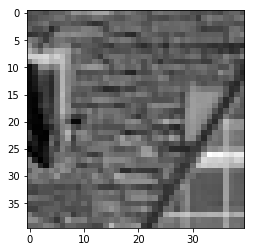

In [13]:
patch2 = list_p[5555,:,:,0]
plt.imshow(patch2, cmap='gray')
print(list_p.shape)